# Estimate rates from SqRA rate matrix 2D

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

### Adjacency matrix

In [2]:
def fluxed_adjancency_matrix(xbins, ybins, Dx, Dy):

    Nbins = xbins * ybins

    A = np.zeros((Nbins,Nbins))
    
    for x in np.arange(xbins):
        for y in np.arange(ybins):
            i = y + ybins * x

            left = x-1
            right = x +1
            
            if x == 0:
                left = xbins-1
            
            if x == xbins-1:
                right = 0

            up = y+1
            down = y-1
            
            if y == 0:
                down = ybins-1
            
            if y == ybins-1:
                up = 0
            
            jleft  = y + ybins * left
            jright = y + ybins * right
            jup    = up   + ybins * x
            jdown  = down + ybins * x
            #print(x,y,i)           
            A[i, jleft]  = Dx
            A[i, jright] = Dx
            A[i, jup]    = Dy
            A[i, jdown]  = Dy
    
    return A

## 2D system

In [3]:
# Potential energy function
def v2d(x, y):
    return (x**2 - 1)**2 + 0.5*y * x + y**2 

# System parameters
kB    = 0.008314463
T     = 300
mass  = 1
gamma = 1
D     = kB * T / mass / gamma
sigma = np.sqrt(2 * D)
beta  = 1 / kB / T

# Grid
nd     =  2  # Number of dimensions
xedges = 40  # x boundaries
xmin   = -2.2
xmax   =  2.2

yedges = 30  # y boundaries
ymin   = -2.2
ymax   =  2.2

x      = np.linspace(xmin, xmax, xedges)  # array with x edges
dx     = x[1] - x[0]
x      = x[:-1] + (dx / 2)                # array with x centers
xbins  = xedges - 1

y      = np.linspace(ymin, ymax, yedges)  # array with x edges
dy     = y[1] - y[0]
y      = y[:-1] + (dy / 2)                # array with x centers
ybins  = yedges - 1

Nbins  = xbins*ybins                      # number of bins

grid = np.meshgrid(x,y)


#### Build SqRA 2D

In [4]:
# Potential energy of states
#v = v2d(*grid).flatten()
v = v2d(grid[0].flatten('F'), grid[1].flatten('F'))
v = v - np.min(v)
# Adjacency matrix times flux
Dx = D / (dx**2)
Dy = D / (dy**2)
Af = fluxed_adjancency_matrix(xbins, ybins, Dx, Dy)

# Diagonalization
SQRA = np.sqrt(np.exp(- beta * v))
SQRA = SQRA / sum(SQRA)
Di   = scipy.sparse.spdiags(SQRA, 0, Nbins, Nbins) #.toarray()
D1   = scipy.sparse.spdiags(1/SQRA, 0, Nbins, Nbins)           

Q    = D1*Af*Di

Q    = Q + scipy.sparse.spdiags(-Q.sum(axis=1).T, 0, Nbins, Nbins)
#eigenval, eigenvec = scipy.sparse.linalg.eigs(Q.T, 4, which='LR')
#plt.pcolor(grid[0],grid[1],np.real(eigenvec[:,1]).reshape(ybins,xbins,  order='F'))


#### Estimate rate from (xA, yA) = (-1.1,  0.3) to  (xB, yB)  =  (1.1,  -0.3)

Rate from (xA, yA) to (xB, yB):  0.33645931008767516


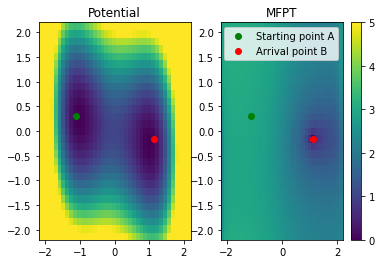

In [5]:
ixA = np.argwhere(np.abs(x + 1.1) < 0.05).item()
iyA = np.argwhere(np.abs(y - 0.3) < 0.05).item()
iA  = iyA + ybins * ixA

ixB = np.argwhere(np.abs(x - 1.1) < 0.05).item()
iyB = np.argwhere(np.abs(y + 0.2) < 0.05).item()
iB  = iyB + ybins * ixB

xA = x[ixA]
yA = y[iyA]
xB = x[ixB]
yB = y[iyB]

Q1         = np.copy(Q)
Q1[iB, :]  = 0.0
Q1[iB, iB] = -1.0
b          = -np.ones(Nbins)
b[iB]      = 0.0
m_t        = np.linalg.solve(Q1, b)
k          = 1/m_t[iA]
m_t        = m_t.reshape(ybins, xbins,order='F')
print('Rate from (xA, yA) to (xB, yB): ', k)
 
fig, (ax1, ax2) = plt.subplots(1, 2)  

ax1.pcolor(grid[0], grid[1], v2d(grid[0], grid[1]), shading='auto', vmax=5)
ax1.plot(xA, yA, 'go',label='Starting point A')
ax1.plot(xB, yB, 'ro',label='Arrival point B')
ax1.set_title('Potential')

pos=ax2.pcolor(grid[0], grid[1], m_t, shading='auto', vmax=5)
ax2.plot(xA, yA, 'go',label='Starting point A')
ax2.plot(xB, yB, 'ro',label='Arrival point B')
ax2.set_title('MFPT')
ax2.legend()
fig.colorbar(pos, ax=ax2)



#### Estimate rate from set around (xA, yA) = (-1.1,  0.3) to set around  (xB, yB)  =  (1.1,  -0.3)

Rate from set A to set B:  0.5741201224021922


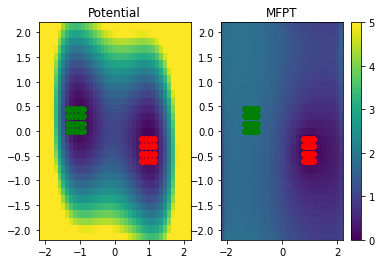

In [6]:
ixAa = np.min(np.argwhere(np.abs(x + 1.3) < 0.08))
ixAb = np.min(np.argwhere(np.abs(x + 0.8) < 0.08))
iyAa = np.min(np.argwhere(np.abs(y - 0.0) < 0.08))
iyAb = np.min(np.argwhere(np.abs(y - 0.6) < 0.08))

ixBa = np.min(np.argwhere(np.abs(x - 0.8) < 0.1))
ixBb = np.min(np.argwhere(np.abs(x - 1.3) < 0.1))
iyBa = np.min(np.argwhere(np.abs(y + 0.6) < 0.1))
iyBb = np.min(np.argwhere(np.abs(y - 0.0) < 0.1))

xA = x[ixAa:ixAb]
yA = y[iyAa:iyAb]

xB = x[ixBa:ixBb]
yB = y[iyBa:iyBb]

setA = np.meshgrid(xA,yA)
setB = np.meshgrid(xB,yB)

indecesA = np.zeros(len(xA) * len(yA))
indecesB = np.zeros(len(xB) * len(yB))

h = 0
for i in range(len(xA)):
    for j in range(len(yA)):
        k  = iyAa + j + ybins * (ixAa + i)
        indecesA[h] =  k
        h = h+1
        
h = 0
for i in range(len(xB)):
    for j in range(len(yA)):
        k  = iyBa + j + ybins * (ixBa + i)
        indecesB[h] =  k
        h = h+1
        


W   = np.exp(- beta * v)
W   = W[indecesA.astype(int)]
W   = W / np.sum(W)

Q2                   = np.copy(Q)

for i in range(len(indecesB)):
    Q2[indecesB[i].astype(int), :] = np.zeros(len(Q2))
    Q2[indecesB[i].astype(int), indecesB[i].astype(int)] = -1.0

b                                 = -np.ones(len(Q2))
b[indecesB.astype(int)]           = 0.0
m_t                               = np.linalg.solve(Q2, b)  #Mean first-passage time to set right (for all possible starting states)
m_t_sets                          = np.dot(W, m_t[indecesA.astype(int)])    #Mean first-passage time from set left to set right

k              = 1/m_t_sets
print('Rate from set A to set B: ', str(k))

m_t        = m_t.reshape(ybins, xbins,order='F')

fig, (ax1, ax2) = plt.subplots(1, 2)  

ax1.pcolor(grid[0], grid[1], v2d(grid[0], grid[1]), shading='auto', vmax=5)
ax1.plot(setA[0], setA[1], 'go',label='Starting point A')
ax1.plot(setB[0], setB[1], 'ro',label='Arrival point B')
ax1.set_title('Potential')

pos=ax2.pcolor(grid[0], grid[1], m_t, shading='auto', vmax=5)
ax2.plot(setA[0], setA[1], 'go',label='Starting point A')
ax2.plot(setB[0], setB[1], 'ro',label='Arrival point B')
ax2.set_title('MFPT')
fig.colorbar(pos, ax=ax2)